# Setup

In [1]:
from truthnet import truthnet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from tqdm.notebook import tqdm
import tikzplotlib as tpl
from datetime import datetime
from IPython.display import display, HTML
import glob
from zedstat import zedstat

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import (
    ExtraTreesClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    auc,
    mean_squared_error,
    precision_recall_curve,
    r2_score,
    roc_curve,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
import optuna

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# Suspects

In [13]:
def _bond_suspects(alpha=0.001):
    bond = truthnet()
    ## load data and infer qnet
    features, samples = bond.load_data(datapath="data/bondcourt.csv")

    time = str(datetime.now())

    bond.fit(fit=True, modelpath=f"qnets/bondcourt/suspects/bondcourt_{time}.joblib")

    bond.getDissonance(
        outfile=f"data/bondcourt/suspects/bondcourt_dissonance_matrix_{time}.csv"
    )

    suspects, uniform_samples = bond.getSuspects(alpha=alpha, return_samples=True)
    suspects.to_csv(f"data/bondcourt/suspects/suspects_{time}.csv")
    uniform_samples.to_csv(f"data/bondcourt/suspects/uniform_samples_{time}.csv")

    with open(
        f"data/bondcourt/suspects/ci_threshold_alpha_{str(alpha)}_{time}.txt", "w"
    ) as fp:
        x = bond.cithreshold
        fp.write("\n".join("{} {}".format(x[0], x[1])))

In [ ]:
[_bond_suspects() for i in tqdm(range(10))]

In [16]:
glob.glob("data/bondcourt/suspects/suspects*.csv")

['data/bondcourt/suspects/suspects_2023-08-14 08:29:19.071075.csv']

In [2]:
suspects = [
    pd.read_csv(df).rename(columns={pd.read_csv(df).columns[0]: "index"})
    for df in glob.glob("data/bondcourt/suspects/suspects*.csv")
]

In [3]:
disson = [
    pd.read_csv(df).mean(axis=1).reset_index().assign(group="non-suspect")
    for df in glob.glob("data/bondcourt/suspects/bondcourt_dissonance*.csv")
]

In [28]:
suspects[0]

,index,mean_dissonance
0,87,0.204749
1,166,0.207232
2,776,0.210910
3,788,0.228224
4,897,0.210883
5,1040,0.221247
6,1161,0.212585


In [23]:
disson[0].mean(axis=1).sort_values(ascending=False)

788     0.228224
1040    0.221247
1161    0.212585
776     0.210910
897     0.210883
          ...   
245     0.000000
893     0.000000
1123    0.000000
1125    0.000000
0       0.000000
Length: 1250, dtype: float64

In [57]:
disson[0].iloc[suspects[0]["index"].values, :]

,index,0,group
87,87,0.204749,suspect
166,166,0.207232,suspect
776,776,0.210910,suspect
788,788,0.228224,suspect
897,897,0.210883,suspect
1040,1040,0.221247,suspect
1161,1161,0.212585,suspect


In [7]:
disson[0].loc[suspects[0]["index"].values, "group"] = "suspect"

In [34]:
disson[0]

,index,0,group
0,0,0.000000,non-suspect
1,1,0.071464,non-suspect
2,2,0.110151,non-suspect
3,3,0.000000,non-suspect
4,4,0.071256,non-suspect
...,...,...,...
1245,1245,0.079407,non-suspect
1246,1246,0.000000,non-suspect
1247,1247,0.033218,non-suspect
1248,1248,0.074066,non-suspect


In [8]:
disson[0]["group"].unique()

array(['non-suspect', 'suspect'], dtype=object)

<Axes: xlabel='0'>

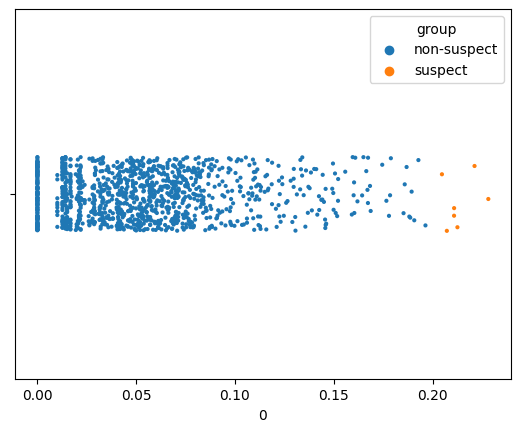

In [9]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.stripplot(data=disson[0], x=0, hue="group", size=3, ax=ax)

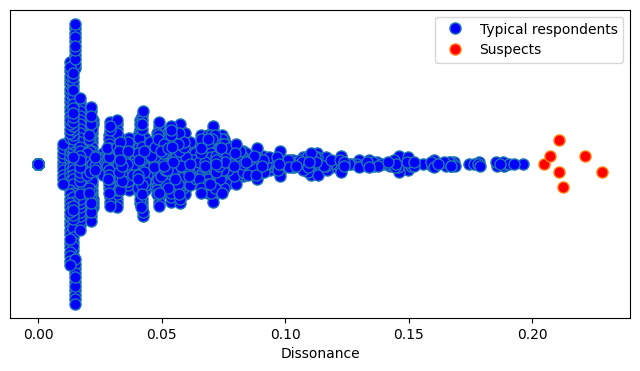

In [52]:
from __future__ import division


def simple_beeswarm2(y, nbins=None, width=1.0):
    """
    Returns x coordinates for the points in ``y``, so that plotting ``x`` and
    ``y`` results in a bee swarm plot.
    """
    y = np.asarray(y)
    if nbins is None:
        # nbins = len(y) // 6
        nbins = np.ceil(len(y) / 6).astype(int)

    # Get upper bounds of bins
    x = np.zeros(len(y))

    nn, ybins = np.histogram(y, bins=nbins)
    nmax = nn.max()

    # Divide indices into bins
    ibs = []  # np.nonzero((y>=ybins[0])*(y<=ybins[1]))[0]]
    for ymin, ymax in zip(ybins[:-1], ybins[1:]):
        i = np.nonzero((y > ymin) * (y <= ymax))[0]
        ibs.append(i)

    # Assign x indices
    dx = width / (nmax // 2)
    for i in ibs:
        yy = y[i]
        if len(i) > 1:
            j = len(i) % 2
            i = i[np.argsort(yy)]
            a = i[j::2]
            b = i[j + 1 :: 2]
            x[a] = (0.5 + j / 3 + np.arange(len(b))) * dx
            x[b] = (0.5 + j / 3 + np.arange(len(b))) * -dx

    return x


fig, ax = plt.subplots(figsize=(8, 4))
# ax.boxplot([disson[0][0].values], widths=0.5, showfliers=False, showcaps=False)
ax.plot(
    disson[0].query("group=='non-suspect'")[0].values,
    simple_beeswarm2(disson[0].query("group=='non-suspect'")[0].values, width=0.1),
    linestyle="None",
    marker="o",
    markerfacecolor="blue",
    markersize=8,
    label="Typical respondents",
)
ax.plot(
    disson[0].query("group=='suspect'")[0].values,
    simple_beeswarm2(disson[0].query("group=='suspect'")[0].values, width=0.01),
    linestyle="None",
    marker="o",
    markerfacecolor="red",
    markersize=8,
    label="Suspects",
)
ax.set_yticks([])
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xlabel("Dissonance")
ax.set_ylabel("")
plt.legend(loc="upper right")
# ax.plot(x2, y, 'o')
# plt.savefig('./swarm_final.png')

In [55]:
from matplotlib.lines import Line2D
from matplotlib.legend import Legend

Line2D._us_dashSeq = property(lambda self: self._dash_pattern[1])
Line2D._us_dashOffset = property(lambda self: self._dash_pattern[0])
Legend._ncol = property(lambda self: self._ncols)

print(
    tpl.get_tikz_code(
        figure=fig,
        standalone=False,
        extra_axis_parameters={"basegridstyle", "ymajorgrids=false", "ytick=\empty"},
    )
)

% This file was created with tikzplotlib v0.10.1.
\begin{tikzpicture}

\definecolor{darkgray176}{RGB}{176,176,176}
\definecolor{darkorange25512714}{RGB}{255,127,14}
\definecolor{lightgray204}{RGB}{204,204,204}
\definecolor{steelblue31119180}{RGB}{31,119,180}

\begin{axis}[
basegridstyle,
legend cell align={left},
legend style={fill opacity=0.8, draw opacity=1, text opacity=1, draw=lightgray204},
tick align=outside,
tick pos=left,
x grid style={darkgray176},
xlabel={Dissonance},
xmin=-0.0114111780263279, xmax=0.239634738552886,
xtick style={color=black},
ymajorgrids=false,
ymin=-0.0488028169014085, ymax=0.0488028169014085,
ytick=\empty
]
\addplot [semithick, steelblue31119180, mark=*, mark size=4, mark options={solid,fill=blue}, only marks]
table {%
0 0
0.071464049854168 -0.00492957746478873
0.110151339634047 -0.00211267605633803
0 0
0.0712561821709476 0.00211267605633803
0 0
0 0
0.149599173072714 -0.000704225352112676
0.0204607046070461 0.00492957746478873
0 0
0.0418672136385856 0.0082

In [27]:
x1

array([ 0.        ,  0.01232394, -0.00880282, ..., -0.02288732,
       -0.02288732, -0.0064554 ])

In [23]:
disson[0][0].values

array([0.        , 0.07146405, 0.11015134, ..., 0.03321839, 0.0740663 ,
       0.07440228])

In [20]:
y1

array([214.08203591, 205.56320618, 296.83643325, 215.70233874,
       246.37110847, 233.34092108, 169.14611537, 151.3470213 ,
       179.14492179, 147.03555529, 196.86316327, 119.57332823,
       213.88780298, 224.00751796, 204.57880753, 239.06071049,
       165.05926922, 144.43715081, 291.12780153, 280.25470391,
       206.80174898, 168.06988161, 265.52833465, 170.61519507,
       181.98899995, 217.79344683, 220.57282734, 141.20294646,
       176.32963727, 220.91217736, 222.58803489, 186.40952817,
       303.04208654, 194.98894528, 206.75092947, 154.34269069,
       217.54271521, 171.5725483 , 169.92550791, 237.37521272,
       196.48390545, 193.53152039, 206.46464127, 217.0541574 ,
       151.7008397 , 189.80962834, 207.14298243, 212.02800291,
       156.64556225, 205.91688013, 191.67484086, 271.53792436,
       132.68172259, 139.6123978 , 180.41545278, 241.87954729,
       279.97832711, 170.76611046, 204.51543656, 117.62076168,
       240.21629845, 224.58116515, 250.94765991, 216.61

<Axes: xlabel='0'>

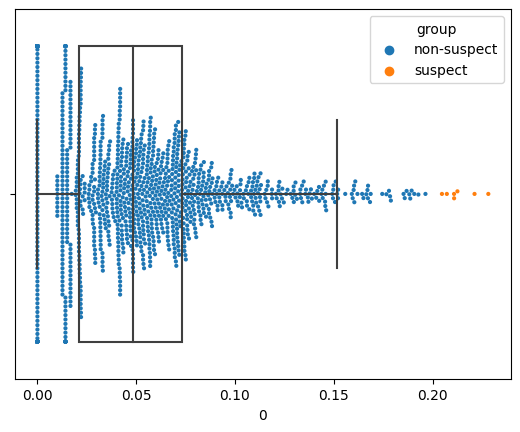

In [18]:
ax = sns.swarmplot(
    data=disson[0],
    x=0,
    hue="group",
    size=3,
)
sns.boxplot(
    data=disson[0],
    x=0,
    zorder=10,
    boxprops={"facecolor": "None", "zorder": 10},
    showfliers=False,
)

In [114]:
from matplotlib.lines import Line2D
from matplotlib.legend import Legend

Line2D._us_dashSeq = property(lambda self: self._dash_pattern[1])
Line2D._us_dashOffset = property(lambda self: self._dash_pattern[0])
Legend._ncol = property(lambda self: self._ncols)

print(
    tpl.get_tikz_code(
        figure=fig, standalone=True, extra_axis_parameters={"basegridstyle"}
    )
)

\documentclass{standalone}
\usepackage[utf8]{inputenc}
\usepackage{pgfplots}
\DeclareUnicodeCharacter{2212}{−}
\usepgfplotslibrary{groupplots,dateplot}
\usetikzlibrary{patterns,shapes.arrows}
\pgfplotsset{compat=newest}
\begin{document}
% This file was created with tikzplotlib v0.10.1.
\begin{tikzpicture}

\definecolor{darkgray176}{RGB}{176,176,176}
\definecolor{darkorange25512714}{RGB}{255,127,14}
\definecolor{darkslategray63}{RGB}{63,63,63}
\definecolor{lightgray204}{RGB}{204,204,204}
\definecolor{steelblue31119180}{RGB}{31,119,180}

\begin{axis}[
basegridstyle,
legend cell align={left},
legend style={fill opacity=0.8, draw opacity=1, text opacity=1, draw=lightgray204},
tick align=outside,
tick pos=left,
x grid style={darkgray176},
xlabel={Dissonance},
xmin=-0.0114111780263279, xmax=0.239634738552886,
xtick style={color=black},
y dir=reverse,
y grid style={darkgray176},
ymin=-0.5, ymax=0.5,
ytick style={color=black}
]
\addplot [draw=steelblue31119180, fill=steelblue31119180, mark=*, 

Text(0, 0.5, '')

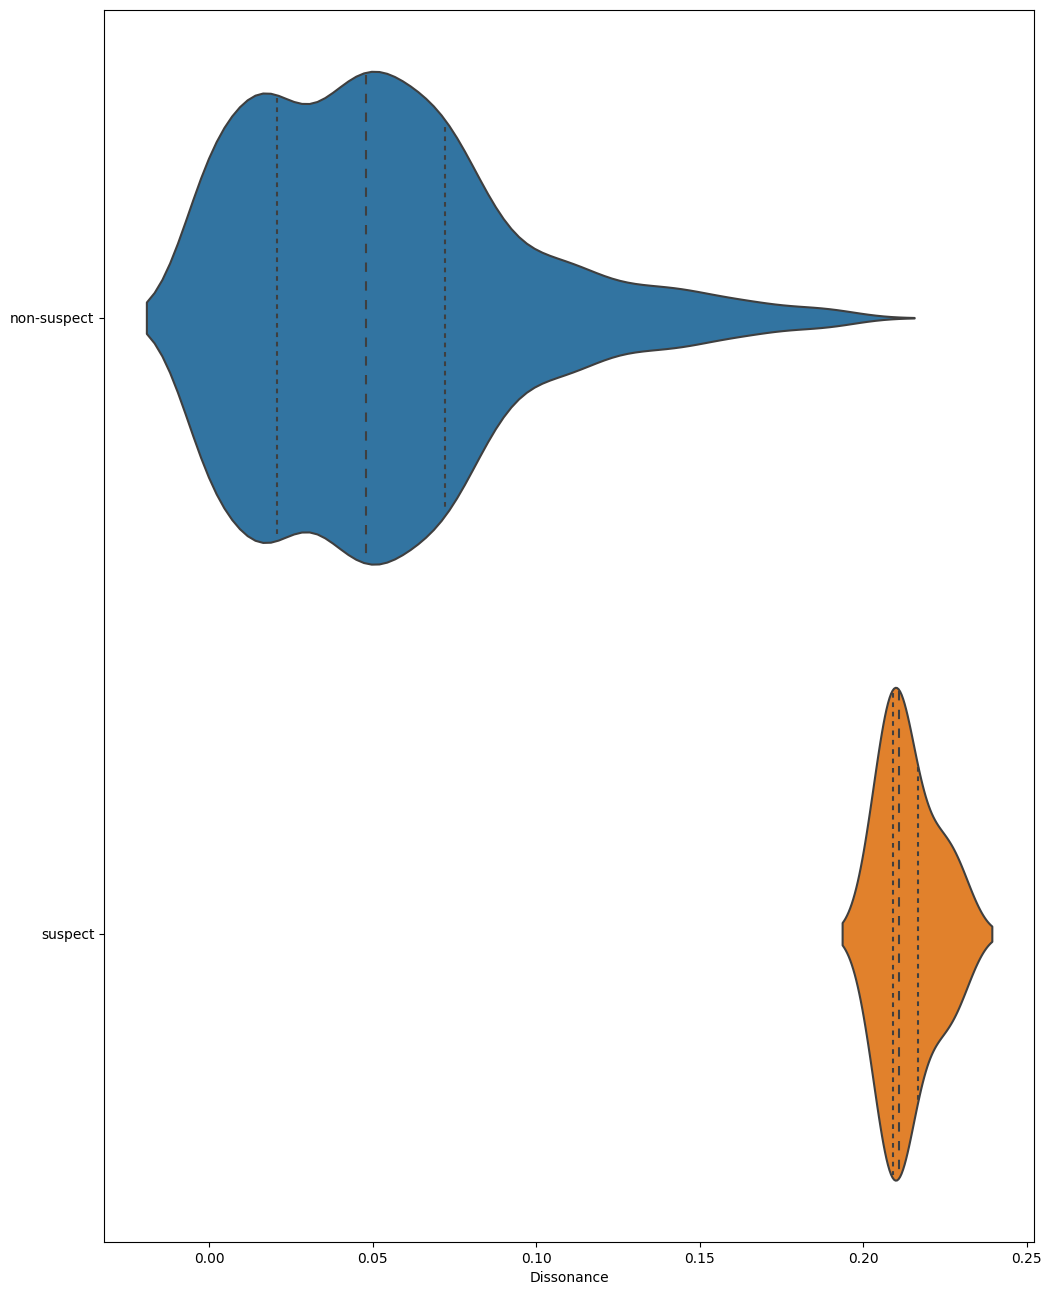

In [102]:
fig, ax = plt.subplots(figsize=(12, 16))
sns.violinplot(data=disson[0], x=0, y="group", ax=ax, scale="width", inner="quartiles")
ax.set_xlabel("Dissonance")
ax.set_ylabel("")

In [108]:
from matplotlib.lines import Line2D
from matplotlib.legend import Legend

Line2D._us_dashSeq = property(lambda self: self._dash_pattern[1])
Line2D._us_dashOffset = property(lambda self: self._dash_pattern[0])
Legend._ncol = property(lambda self: self._ncols)

print(
    tpl.get_tikz_code(
        figure=fig, standalone=False, extra_axis_parameters={"basegridstyle"}
    )
)

% This file was created with tikzplotlib v0.10.1.
\begin{tikzpicture}

\definecolor{darkgray176}{RGB}{176,176,176}
\definecolor{darkslategray63}{RGB}{63,63,63}
\definecolor{peru22412844}{RGB}{224,128,44}
\definecolor{steelblue49115161}{RGB}{49,115,161}

\begin{axis}[
basegridstyle,
tick align=outside,
tick pos=left,
x grid style={darkgray176},
xlabel={Dissonance},
xmin=-0.0321521297454852, xmax=0.252312808438951,
xtick style={color=black},
y dir=reverse,
y grid style={darkgray176},
ymin=-0.5, ymax=1.5,
ytick style={color=black},
ytick={0,1},
yticklabels={non-suspect,suspect}
]
\path [draw=darkslategray63, fill=steelblue49115161, semithick]
(axis cs:-0.0192219052825563,0.0254993119354958)
--(axis cs:-0.0192219052825563,-0.0254993119354958)
--(axis cs:-0.0168496553638313,-0.0409058162730443)
--(axis cs:-0.0144774054451064,-0.0619777645910246)
--(axis cs:-0.0121051555263815,-0.0888272038147887)
--(axis cs:-0.00973290560765652,-0.12067885740869)
--(axis cs:-0.00736065568893158,-0.155858638

In [4]:
pd.DataFrame(
    {
        "suspects": disson[0]
        .rename(columns={0: "dissonance"})
        .query("group=='suspect'")["dissonance"],
        "non-suspects": disson[0]
        .rename(columns={0: "dissonance"})
        .query("group=='non-suspect'")["dissonance"],
    }
).reset_index().to_csv("bondcourt-suspects-all-dissonance.dat", sep=" ", index=False)

In [97]:
pd.DataFrame(
    {
        "suspects": disson[0]
        .rename(columns={0: "dissonance"})
        .query("group=='suspect'")["dissonance"]
    }
).reset_index().to_csv("bondcourt-suspects-dissonance.csv", index=False)

pd.DataFrame(
    {
        "non-suspects": disson[0]
        .rename(columns={0: "dissonance"})
        .query("group=='non-suspect'")["dissonance"],
    }
).reset_index().to_csv("bondcourt-nonsuspects-dissonance.csv", index=False)

In [2]:
bond = truthnet()
## load data and infer qnet
features, samples = bond.load_data(datapath="data/bondcourt.csv")

bond.fit(fit=True, modelpath="tmp_bondcourt.joblib")

In [3]:
bond.dissonance = pd.read_csv("mpi_tmp/bondcourt_dissonance.csv")

In [8]:
suspects, usamples = bond.getSuspects(alpha=0.001, return_samples=True)
usamples

,6294,6296,6298,6314,6315,6317,6319,6325,6326,6327,...,6411,6412,6421,6422,6426,6427,6436,6463,6464,6465
0,,2.0,1.0,4.0,3.0,4.0,3.0,,,2.0,...,4.0,,2.0,1.0,1.0,4.0,1.0,0.0,0.0,0.0
1,2.0,2.0,1.0,4.0,2.0,3.0,1.0,,1.0,2.0,...,3.0,4.0,4.0,,4.0,5.0,1.0,0.0,0.0,0.0
2,,1.0,1.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,...,4.0,2.0,,1.0,,7.0,1.0,0.0,0.0,0.0
3,,1.0,1.0,4.0,3.0,1.0,1.0,2.0,1.0,,...,1.0,3.0,2.0,3.0,1.0,8.0,4.0,0.0,0.0,0.0
4,2.0,1.0,,1.0,4.0,3.0,4.0,1.0,1.0,,...,5.0,1.0,,1.0,1.0,5.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,,2.0,,1.0,1.0,2.0,3.0,2.0,1.0,1.0,...,2.0,5.0,,4.0,2.0,9.0,1.0,0.0,0.0,0.0
1246,1.0,1.0,,1.0,2.0,4.0,2.0,2.0,1.0,1.0,...,,,2.0,,4.0,1.0,1.0,0.0,0.0,0.0
1247,,2.0,,2.0,1.0,3.0,4.0,1.0,1.0,1.0,...,3.0,2.0,2.0,2.0,,2.0,,0.0,0.0,0.0
1248,,1.0,,4.0,2.0,3.0,1.0,,,2.0,...,,4.0,4.0,5.0,5.0,1.0,,0.0,0.0,0.0


In [5]:
COLS = pd.read_csv("data/bondcourt/CCHHS_SUD_details.csv", index_col=0).columns
ID = pd.read_csv("data/bondcourt/CCHHS_SUD_details.csv", index_col=0).index.values
df = pd.DataFrame(
    pd.read_csv("data/bondcourt/CCHHS_SUD_details.csv", index_col=0).values,
    columns=COLS,
)
df.index = ID

In [6]:
bond.dissonance.mean(axis=1)

0       0.000000
1       0.071464
2       0.110161
3       0.000000
4       0.071256
          ...   
1245    0.079407
1246    0.000000
1247    0.033218
1248    0.074066
1249    0.074694
Length: 1250, dtype: float64

In [12]:
suspects

,mean_dissonance
776,0.214139
788,0.230059
897,0.211360
1040,0.217627
1161,0.214471


In [7]:
sf = suspects.join(pd.read_csv("data/bondcourt.csv", names=COLS))
sf.index = ID[sf.index]
sf

,mean_dissonance,11713,6294,6295,6296,6297,6298,6299,6300,6301,...,6456,6457,6458,6459,6460,6461,6462,6463,6464,6465
52997,0.208809,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
71607,0.214139,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
71672,0.230059,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
73645,0.211360,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
79156,0.217627,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
82730,0.214471,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [ ]:
bond.getDissonance(outfile="mpi_tmp/bondcourt_dissonance.csv")

In [2]:
def _bondDissonance():
    bond = truthnet()
    features, samples = bond.load_data(datapath="data/bondcourt.csv")
    bond.fit(modelpath="tmp_Qnet.joblib")

    time = str(datetime.now())

    bond.getDissonance(
        outfile="data/bondcourt/bondcourt_dissonance_matrix" + time + ".csv"
    )

    return bond

In [18]:
suspects = bond.getSuspects(alpha=0.05)
suspects.join(pd.read_csv("data/bondcourt.csv"))

,mean_dissonance,11713,6294,6295,6296,6297,6298,6299,6300,6301,...,6456,6457,6458,6459,6460,6461,6462,6463,6464,6465


# Distribution fit

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 124.95] [loc=0.053 scale=0.042]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 112.792] [loc=0.000 scale=0.053]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 590.429] [loc=-0.000 scale=0.000]
[distfit] >INFO> [dweibull  ] [0.01 sec] [RSS: 115.644] [loc=0.050 scale=0.033]
[distfit] >INFO> [t         ] [0.08 sec] [RSS: 105.407] [loc=0.048 scale=0.034]
[distfit] >INFO> [genextreme] [0.12 sec] [RSS: 80.239] [loc=0.033 scale=0.030]
[distfit] >INFO> [gamma     ] [0.06 sec] [RSS: 237.373] [loc=-0.000 scale=0.050]
[distfit] >INFO> [lognorm   ] [0.04 sec] [RSS: 74.3431] [loc=-0.031 scale=0.075]
[distfit] >INFO> [beta      ] [0.10 sec] [RSS: 124.753] [loc=-0.000 scale=0.639]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 469.154] [loc=0.000 scale=0.228]
[distfit] >INFO> [loggamma  ] [0.05 sec] [RSS: 128.94] [loc=-15.250 scale=1.983]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] 

(<Figure size 2000x1500 with 1 Axes>,
 <AxesSubplot:title={'center':'\nlognorm(s=0.493366, loc=-0.0311699, scale=0.0748801)'}, xlabel='Values', ylabel='Frequency'>)

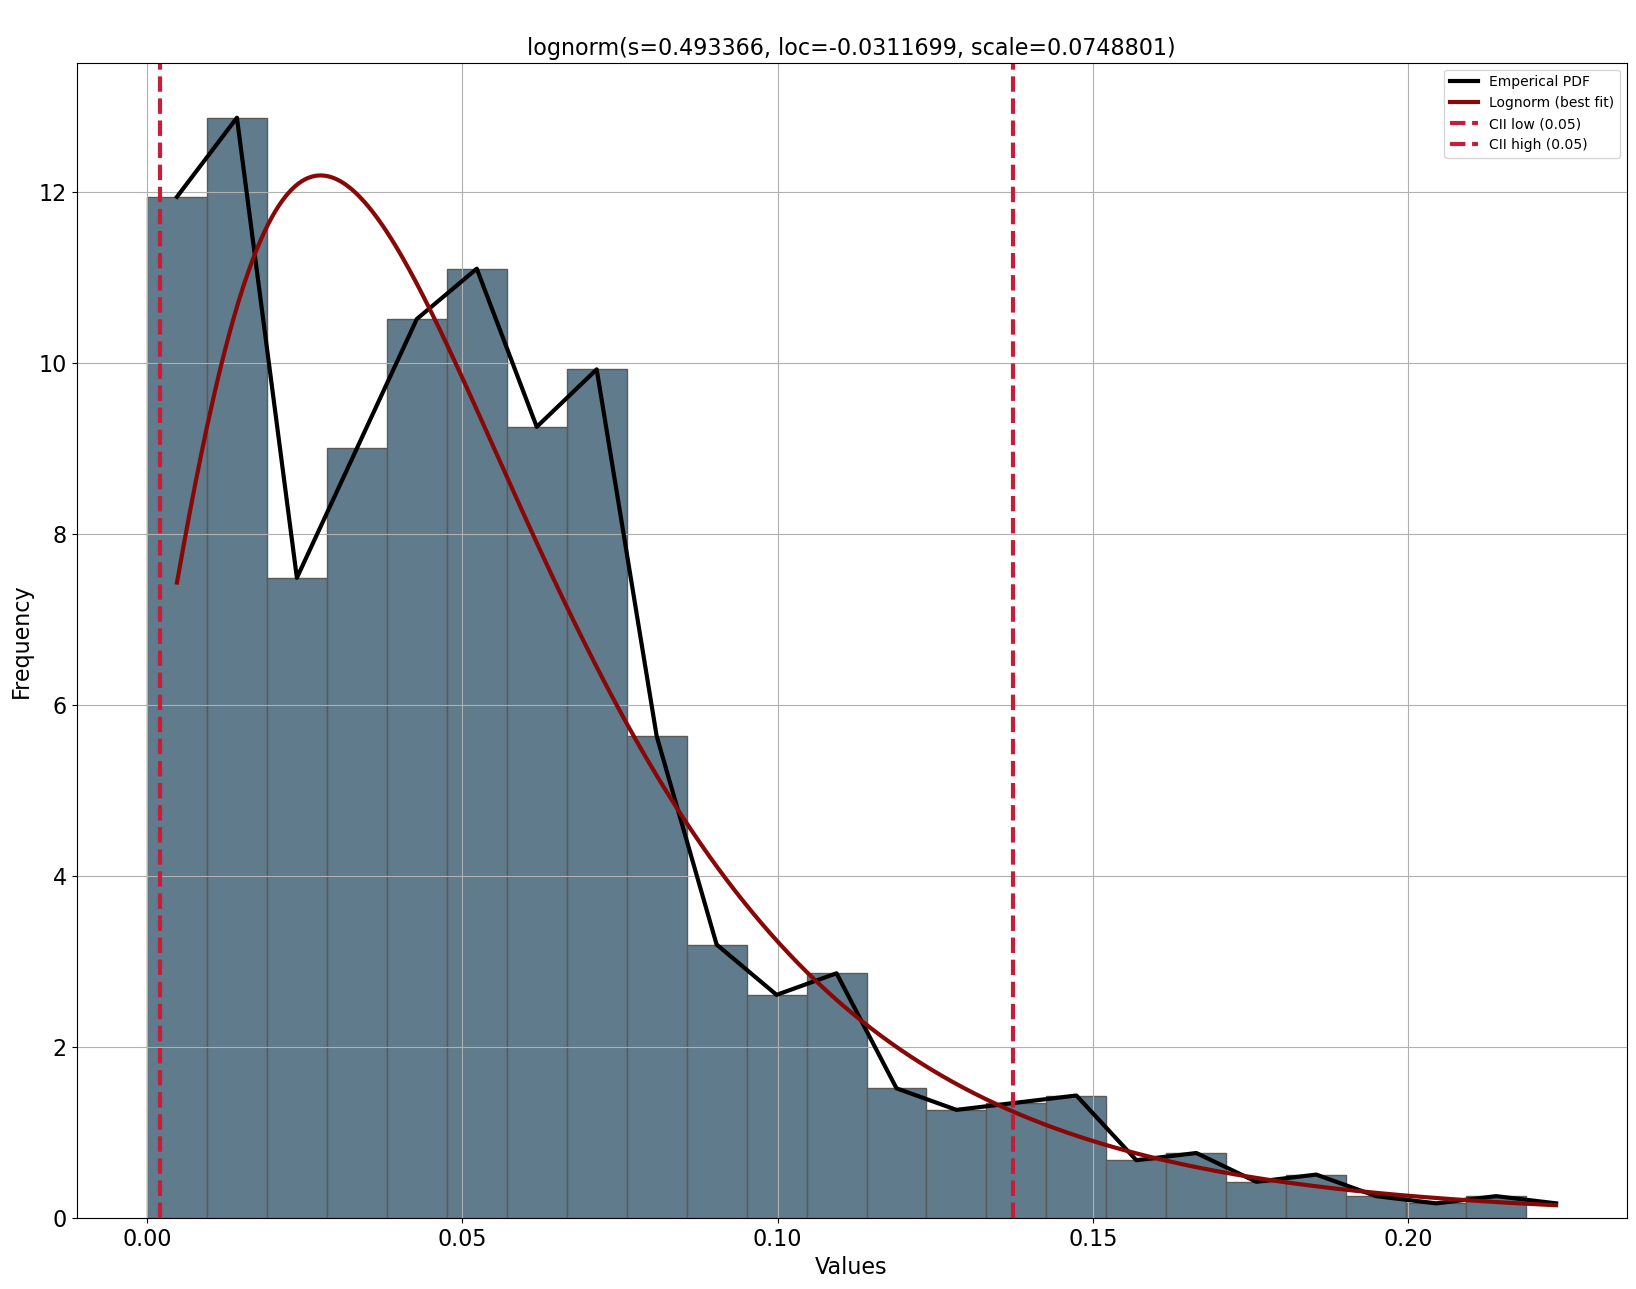

In [3]:
from distfit import distfit

# Example data
X = pd.read_csv("data/bondcourt/suspects_disson_all.csv")["dissonance"].to_numpy()

# Initialize distfit object
dfit = distfit(distr="popular")

# Fit distributions on empirical data X
dfit.fit_transform(X)

# Plot the best fitted distribution
dfit.plot()

In [4]:
dfit.model["params"]

(0.49336619967765416, -0.031169944503724966, 0.07488011692523915)

In [5]:
x = np.linspace(np.min(X), np.max(X), 1000)
y = dfit.model["model"].pdf(x)

pd.DataFrame({"x": x, "y": y}).to_csv(
    "data/bondcourt/dist_fit_lognormal.csv", index=False
)

# Compute dissonance under sampling scenarios

In [2]:
from quasinet.qsampling import qsample
from scipy.stats import entropy
import random
from quasinet.utils import sample_from_dict


def _get_qnet(df):
    from quasinet import qnet

    qn = qnet.Qnet(
        feature_names=df.columns.values,
        min_samples_split=2,
        alpha=0.05,
        max_depth=-1,
        max_feats=-1,
        early_stopping=False,
        verbose=0,
        random_state=None,
        n_jobs=-1,
    )

    qn.fit(df.to_numpy(dtype="<U21"))

    return qn


def _get_tnets(
    df,
    df_pos=None,
    df_neg=None,
    calibration_samples=500,
    diss_file="data/bondcourt/bondcourt_dissonance.csv",
):
    if df_pos is not None and df_neg is not None:
        non_null_cols = (
            (df.isna().sum() < len(df))
            & (df_pos.isna().sum() < len(df_pos))
            & (df_neg.isna().sum() < len(df_neg))
        )
        Tr = _get_qnet(df.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, ""))
        Tr_pos = _get_qnet(
            df_pos.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
        )
        Tr_neg = _get_qnet(
            df_neg.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
        )
    else:
        bond = truthnet()
        length = sum(df.isna().sum() < len(df))
        features, samples = bond.load_data(datapath="data/bondcourt.csv")
        bond.fit(modelpath="tmp_Qnet.joblib")
        if diss_file is not None:
            bond.dissonance = pd.read_csv(diss_file)
        else:
            bond.getDissonance(
                outfile="data/bondcourt/tmp_bondcourt_dissonance_matrix.csv"
            )
        coresamples = bond.getCoresamples(alpha=0.01, steps=length)
        df_neg = df.loc[coresamples.index.values]
        # sample = np.full(length, "")
        # calibration_samples = np.array(
        #    [qsample(sample, Tr, length) for i in range(calibration_samples)]
        # )
        # df_pos = pd.DataFrame(calibration_samples).set_axis(
        #    Tr.feature_names, axis="columns"
        # )
        df_pos = df.loc[~df.index.isin(coresamples.index.values)]

        non_null_cols = (
            (df.isna().sum() < len(df))
            & (df_pos.isna().sum() < len(df_pos))
            & (df_neg.isna().sum() < len(df_neg))
        )

        Tr = _get_qnet(df.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, ""))
        Tr_neg = _get_qnet(
            df_neg.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
        )
        Tr_pos = _get_qnet(
            df_pos.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
        )

    return {
        "all": Tr,
        "pos": Tr_pos,
        "neg": Tr_neg,
        "data": df.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, ""),
    }


def _diss_linear(s, qnet):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(1 - Ds[i][s[i]] / np.max(list(Ds[i].values())))
            else:
                diss.append(1)

    return np.array(diss)


def _diss_log(s, qnet):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(-np.log(Ds[i][s[i]]))
            else:
                diss.append(np.inf)

    return np.array(diss)


def _sample_with_dissonance(
    sample_model,
    length,
    diss_models,
    diss_fcn=_diss_linear,
    order=None,
    data_samples=None,
):
    if order is None:
        order = range(length)

    if data_samples is not None:
        data_samples_df = pd.DataFrame(data_samples)
        data_sample_values = pd.Series(
            {
                col: [x for x in data_samples_df[col].unique() if x != ""]
                for col in data_samples_df
            }
        )

    sample = np.full(length, "")

    diss = [list() for model in diss_models]

    for i in order:
        if sample_model is not None:
            prob_dict = sample_model.predict_distribution(sample, i)
            sample[i] = sample_from_dict(prob_dict)
        else:
            sample[i] = random.choice(data_sample_values[i])
        [d.append(diss_fcn(sample, model)) for d, model in zip(diss, diss_models)]

    return sample, diss


def _nsamples_with_dissonance(
    n_samples,
    sample_model,
    length,
    diss_models,
    diss_fcn=_diss_linear,
    order=None,
    data_samples=None,
):
    samples = list()
    dissonances = list()

    for i in tqdm(range(n_samples)):
        samp, diss = _sample_with_dissonance(
            sample_model,
            length,
            diss_models,
            diss_fcn,
            order,
            data_samples,
        )
        samples.append(samp)
        dissonances.append(diss)

    return samples, dissonances


def _dissonance_data_at_question(dissonances, questions_asked):
    return np.array(
        [np.hstack([d[questions_asked - 1] for d in diss]) for diss in dissonances]
    )


# generate samples under the given models and compute dissonances under specified diss_models
def _sampling_scenario(
    n_qsamples,
    qsample_model,
    n_m2_samples,
    m2_model,
    diss_models,
    length,
    n_runif_samples=None,
    diss_fcn=_diss_linear,
    order=None,
    data_samples=None,
):
    samples = {}
    dissonances = {}

    if order == "entropy":
        Ds = qsample_model.predict_distributions(np.full(length, ""))
        entrpy = list()
        for i in range(len(Ds)):
            entrpy.append(entropy(np.fromiter(Ds[i].values(), dtype=float)))
        order = pd.Series(entrpy).sort_values().index

    if order == "random":
        order = list(range(length))
        random.shuffle(order)

    samples["qsampled"], dissonances["qsampled"] = _nsamples_with_dissonance(
        n_qsamples, qsample_model, length, diss_models, diss_fcn, order
    )

    samples["m2"], dissonances["m2"] = _nsamples_with_dissonance(
        n_m2_samples, m2_model, length, diss_models, diss_fcn, order
    )

    if n_runif_samples is not None:
        samples["runif"], dissonances["runif"] = _nsamples_with_dissonance(
            n_runif_samples,
            None,
            length,
            diss_models,
            diss_fcn,
            order,
            data_samples,
        )

    return samples, dissonances


def _diss_dataset(dissonances, questions_asked, groups=["qsampled", "m2"]):
    diss_dataset = pd.concat(
        [
            pd.DataFrame(
                _dissonance_data_at_question(dissonances[group], questions_asked)
            ).assign(y=group)
            for group in groups
        ]
    )
    return diss_dataset


def _save_sampling_scenarios(
    iter,
    n_qsamples,
    n_m2_samples,
    diss_fcn=_diss_linear,
    order=None,
    n_runif_samples=None,
    invert_pos=False,
):
    for i in tqdm(iter):
        bond = _get_tnets(
            df=pd.read_csv("data/bondcourt/CCHHS_SUD_details.csv").drop(
                "Interview_ID", axis="columns"
            ),
            calibration_samples=500,
            diss_file=None,
        )

        data_samples = bond["data"]
        full_model = bond["all"]
        if invert_pos is True:
            pos_model = bond["neg"]
            neg_model = bond["pos"]
        else:
            pos_model = bond["pos"]
            neg_model = bond["neg"]

        length = len(full_model.feature_names)

        diss_models = [full_model, neg_model, pos_model]

        s, d = _sampling_scenario(
            n_qsamples,
            full_model,
            n_m2_samples,
            pos_model,
            diss_models,
            length,
            n_runif_samples,
            diss_fcn,
            order,
            data_samples=data_samples,
        )

        pd.to_pickle(
            s, "disson_bond/samps_qmr_bond_" + str(order) + "_order_" + str(i) + ".pkl"
        )
        pd.to_pickle(
            d, "disson_bond/disson_qmr_bond_" + str(order) + "_order_" + str(i) + ".pkl"
        )

Example:

In [71]:
bond = _get_tnets(
    df=pd.read_csv("data/bondcourt/CCHHS_SUD_details.csv").drop(
        "Interview_ID", axis="columns"
    ),
    calibration_samples=500,
    diss_file="data/bondcourt/bondcourt_dissonance.csv",
)

QUEUEING TASKS | :   0%|          | 0/1250 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1250 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1250 [00:00<?, ?it/s]

In [4]:
print(
    bond["all"].estimators_[1].labels_,
    bond["pos"].estimators_[1].labels_,
    bond["neg"].estimators_[1].labels_,
)

['1' '2'] ['1' '2'] ['1' '2']


In [83]:
data_samples_df = pd.DataFrame(bond["data"])
data_sample_values = pd.Series(
    {
        col: [x for x in data_samples_df[col].unique() if x != ""]
        for col in data_samples_df
    }
)

In [84]:
data_sample_values[0]

[1, 2]

In [72]:
bond["data"]

,6294,6296,6298,6314,6315,6317,6319,6325,6326,6327,...,6411,6412,6421,6422,6426,6427,6436,6463,6464,6465
0,1,1,,1,1,1,1,,,,...,1,1,,1,1,,,0,0,0
1,,2,,4,4,4,4,,,,...,,,,,,,,0,0,0
2,,1,,1,1,2,1,,,,...,3,1,1,1,,3,1,0,0,0
3,1,1,,1,1,1,1,,,,...,1,1,,1,1,,,0,0,0
4,,2,,1,1,1,1,2,,,...,,,,5,,,,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,,2,,1,2,3,2,,,1,...,,,,,,,,0,0,0
1246,1,1,,1,1,1,1,,,,...,1,1,,1,1,,,0,0,0
1247,,1,,1,1,2,1,,,,...,1,,1,1,,,,0,0,0
1248,,2,,2,3,2,3,,,2,...,,,,,,,,0,0,0


In [ ]:
full_model = bond["all"]
pos_model = bond["pos"]
neg_model = bond["neg"]

diss_models = [full_model, neg_model, pos_model]
n_qsamples = 10
n_m2_samples = 10

s, d = _sampling_scenario(
    n_qsamples,
    full_model,
    n_m2_samples,
    pos_model,
    diss_models,
    len(full_model.feature_names),
)

In [6]:
questions_asked = 32
_diss_dataset(d, questions_asked)

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,y
0,0.93645,0.639281,0.0,0.000000,0.000000,0.0,0.000000,0.775720,0.0,1.000000,...,0.333333,0.4,0.000000,0.875,0.000000,1.000000,0.000000,0.000000,0.000000,qsampled
1,0.00000,0.638988,0.0,0.000000,0.000000,0.0,0.000000,0.775720,0.0,1.000000,...,0.000000,0.4,0.706369,0.000,0.000000,1.000000,0.000000,0.000000,0.000000,qsampled
2,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.666667,0.4,0.000000,0.500,0.000000,0.000000,0.888889,0.000000,0.000000,qsampled
3,0.00000,0.000000,0.0,0.950252,0.000000,0.0,0.000000,0.611984,0.0,1.000000,...,0.333333,0.0,0.000000,0.500,0.000000,0.847222,0.000000,1.000000,0.999453,qsampled
4,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.939293,0.000000,0.0,0.000000,...,0.333333,0.4,0.000000,0.500,0.000000,0.000000,0.000000,1.000000,0.000000,qsampled
5,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.942906,0.441240,0.0,0.000000,...,0.666667,0.4,0.616360,0.000,0.953846,0.000000,1.000000,0.000000,0.657428,qsampled
6,0.00000,0.639281,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.333333,0.4,0.706369,0.125,0.000000,0.000000,0.000000,1.000000,0.000000,qsampled
7,0.00000,0.637662,0.0,0.000000,0.000000,0.0,0.000000,0.775720,0.0,1.000000,...,0.333333,0.0,0.000000,0.875,0.953846,0.000000,0.888889,0.825397,0.000000,qsampled
8,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1.000000,...,0.000000,0.4,0.000000,0.875,0.000000,0.000000,0.888889,0.000000,0.000000,qsampled
9,0.00000,0.574006,0.0,0.000000,0.000000,0.0,0.873688,0.000000,0.0,0.423729,...,0.666667,0.4,0.685674,0.875,0.000000,0.833333,0.000000,0.000000,0.657428,qsampled


Generate/save some dissonance scenarios:

In [ ]:
_save_sampling_scenarios(range(10), 50, 50, order="random", invert_pos=True)

Scenario 3 (m2 from core samples) with added runif samples:

In [ ]:
_save_sampling_scenarios(
    iter=range(10),
    n_qsamples=100,
    n_m2_samples=100,
    order="random",
    n_runif_samples=100,
    invert_pos=True,
)

# Classification

In [4]:
diss = [
    pd.read_pickle(d)
    for d in glob.glob("disson_bond/disson_qmr_bond_random_order*.pkl")
]

samps = [
    pd.read_pickle(d) for d in glob.glob("disson_bond/samps_qmr_bond_random_order*.pkl")
]

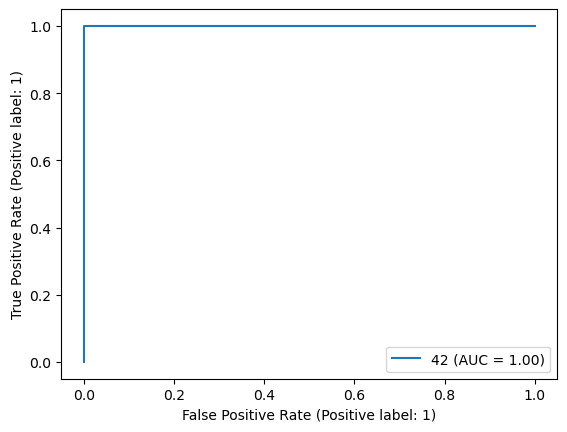

In [5]:
groups = ["qsampled", "runif"]

questions_asked = 42
data = _diss_dataset(diss[0], questions_asked, groups=groups)
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("y", axis="columns"), data["y"], test_size=0.33
)

fig, ax = plt.subplots()

classifier = RandomForestClassifier(n_jobs=-1)

classifier.fit(
    X_train.to_numpy(),
    y_train.replace(
        {
            groups[0]: 0,
            groups[1]: 1,
        }
    ),
)

r = RocCurveDisplay.from_estimator(
    classifier,
    X_test.to_numpy(),
    y_test.replace(
        {
            groups[0]: 0,
            groups[1]: 1,
        }
    ),
    pos_label=1,
    ax=ax,
    name=questions_asked,
)

Below, note that each dissonance file contains dissonances computed on retrained qnets (one set of qnets per file).  We also fit a classifier `retrains` times to get average performance on each file/set of models.

In [11]:
groups = ["qsampled", "runif"]

auc_dfs = list()
plot = False
retrains = 3
n_trials = 20
question_iter = range(1, 45, 3)
res = "all_diss"

classifier = RandomForestClassifier(n_jobs=-1)
# classifier = lgb.LGBMClassifier()


# for each dissonance file
for d in tqdm(diss[8:], desc="Dissonance files"):
    # repeat performance calc
    for _ in tqdm(range(retrains), desc="Training cycles this file"):
        fig, ax = plt.subplots()
        aucs = list()
        z_aucs = list()
        z_aucs_lb = list()
        z_aucs_ub = list()
        roc_dfs = list()

        # which computes the auc for classifier at each question marker
        for questions_asked in question_iter:
            data = _diss_dataset(d, questions_asked, groups=groups)
            X_train, X_test, y_train, y_test = train_test_split(
                data.drop("y", axis="columns"), data["y"], test_size=0.33
            )

            # X_train = X_train.mean(axis=1)
            # X_test = X_test.mean(axis=1)

            def objective(trial):
                # pruning_callback = optuna.integration.LightGBMPruningCallback(
                #    trial, "auc"
                # )

                param = {
                    "n_estimators": trial.suggest_int("n_estimators", 50, 250),
                    "max_depth": trial.suggest_int("max_depth", 5, 15),
                    "min_samples_split": trial.suggest_int("min_samples_split", 10, 30),
                }
                # param = {
                #    "objective": "binary",
                #    "metric": "auc",
                #    "verbosity": -1,
                #    "boosting_type": "gbdt",
                #    "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
                #    "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
                #    "num_leaves": trial.suggest_int("num_leaves", 2, 256),
                #    "feature_fraction": trial.suggest_float(
                #        "feature_fraction", 0.4, 1.0
                #    ),
                #    "bagging_fraction": trial.suggest_float(
                #        "bagging_fraction", 0.4, 1.0
                #    ),
                #    "bagging_freq": trial.suggest_int("bagging_freq", 1, #7),
                #    "min_child_samples": trial.suggest_int#("min_child_samples", 5, 100),
                # }

                classifier.set_params(**param)
                classifier.fit(
                    X_train.to_numpy(),
                    y_train.replace(
                        {
                            groups[0]: 0,
                            groups[1]: 1,
                        }
                    ),
                    # callbacks=[pruning_callback],
                )

                r = RocCurveDisplay.from_estimator(
                    classifier,
                    X_test.to_numpy(),
                    y_test.replace(
                        {
                            groups[0]: 0,
                            groups[1]: 1,
                        }
                    ),
                    pos_label=1,
                    ax=ax,
                    name=questions_asked,
                )

                return r.roc_auc

            study = optuna.create_study(
                # pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
                direction="maximize",
            )
            func = lambda trial: objective(trial, param)
            study.optimize(objective, n_trials=n_trials)

            classifier.set_params(**study.best_trial.params)
            classifier.fit(
                X_train.to_numpy(),
                y_train.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
            )

            r = RocCurveDisplay.from_estimator(
                classifier,
                X_test.to_numpy(),
                y_test.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
                pos_label=1,
                ax=ax,
                name=questions_asked,
            )
            aucs.append(r.roc_auc)
            fpr, tpr, thresholds = roc_curve(
                y_test.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
                classifier.predict_proba(X_test.to_numpy())[:, 1],
                pos_label=1,
            )
            roc_df = pd.DataFrame({"fpr": fpr, "tpr": tpr, "threshold": thresholds})
            roc_dfs.append(roc_df.assign(questions=questions_asked))
            if plot is False:
                plt.close()

            try:
                zt = zedstat.processRoc(
                    roc_df,
                    order=3,
                    total_samples=1000,
                    positive_samples=150,
                    alpha=0.01,
                    prevalence=0.15,
                )

                zt.smooth(STEP=0.01)
                zt.allmeasures(interpolate=False)
                zt.usample(precision=3)
                zt.getBounds()
                z_aucs.append(zt.auc()[0])
                z_aucs_lb.append(zt.auc()[2])
                z_aucs_ub.append(zt.auc()[1])
            except:
                z_aucs.append(r.roc_auc)
                z_aucs_lb.append(r.roc_auc)
                z_aucs_ub.append(r.roc_auc)

        auc_df = pd.DataFrame(
            {
                "questions asked": question_iter,
                "auc": aucs,
                "z_auc": z_aucs,
                "z_auc_lb": z_aucs_lb,
                "z_auc_ub": z_aucs_ub,
            }
        )

        if plot is True:
            ax = auc_df.plot(x="questions asked", y="z_auc")
            ax.fill_between(
                auc_df["questions asked"],
                auc_df["z_auc_ub"],
                auc_df["z_auc_lb"],
                alpha=0.25,
            )

        time = str(datetime.now())

        pd.concat(roc_dfs).to_csv(
            "data/classification/bondcourt/rf_auc_res/roc_df_rf_"
            + "_runif_random_order_"
            + time
            + ".csv",
            index=False,
        )
        auc_dfs.append(auc_df)
        auc_df.to_csv(
            "data/classification/bondcourt/rf_auc_res/auc_df_rf_"
            + "_runif_random_order_"
            + time
            + ".csv",
            index=False,
        )
    pd.concat(auc_dfs).groupby(level=0).mean().to_csv(
        "data/classification/bondcourt/rf_auc_res/auc_dfs_rf_"
        + "_runif_random_order_"
        + str(datetime.now())
        + ".csv",
        index=False,
    )

Dissonance files:   0%|          | 0/2 [00:00<?, ?it/s]

Training cycles this file:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2023-08-21 19:42:37,515] A new study created in memory with name: no-name-eb02e886-522f-4e30-9711-97a0a7de3193
[I 2023-08-21 19:42:37,833] Trial 0 finished with value: 0.876492194674013 and parameters: {'n_estimators': 228, 'max_depth': 15, 'min_samples_split': 27}. Best is trial 0 with value: 0.876492194674013.
[I 2023-08-21 19:42:38,028] Trial 1 finished with value: 0.876492194674013 and parameters: {'n_estimators': 141, 'max_depth': 5, 'min_samples_split': 10}. Best is trial 0 with value: 0.876492194674013.
[I 2023-08-21 19:42:38,211] Trial 2 finished with value: 0.876492194674013 and parameters: {'n_estimators': 133, 'max_depth': 13, 'min_samples_split': 24}. Best is trial 0 with value: 0.876492194674013.
[I 2023-08-21 19:42:38,293] Trial 3 finished with value: 0.876492194674013 and parameters: {'n_estimators': 54, 'max_depth': 12, 'min_samples_split': 21}. Best is trial 0 with value: 0.876492194674013.
[I 2023-08-21 19:42:38,617] Trial 4 finished with value: 0.876492194674013 a

Training cycles this file:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2023-08-21 19:47:13,671] A new study created in memory with name: no-name-30ab95d9-ec54-474f-a8ec-8f86ac018494
[I 2023-08-21 19:47:13,805] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 95, 'max_depth': 5, 'min_samples_split': 24}. Best is trial 0 with value: 0.5.
[I 2023-08-21 19:47:13,881] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 50, 'max_depth': 11, 'min_samples_split': 29}. Best is trial 0 with value: 0.5.
[I 2023-08-21 19:47:14,016] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 104, 'max_depth': 13, 'min_samples_split': 26}. Best is trial 0 with value: 0.5.
[I 2023-08-21 19:47:14,300] Trial 3 finished with value: 0.5 and parameters: {'n_estimators': 208, 'max_depth': 12, 'min_samples_split': 18}. Best is trial 0 with value: 0.5.
[I 2023-08-21 19:47:14,389] Trial 4 finished with value: 0.5 and parameters: {'n_estimators': 66, 'max_depth': 5, 'min_samples_split': 23}. Best is trial 0 with value: 0.5.
[I 2023-08-21 19

## Results

Scenario 1

In [6]:
conf = 0.95

rf_res = pd.concat(
    [
        pd.read_csv(df)
        for df in glob.glob("data/classification/bondcourt/rf_auc_res/auc_df_rf*.csv")
    ]
)

rf_auc_ci_var = rf_res.groupby(["questions asked"], as_index=False).agg(
    mean=pd.NamedAgg(column="auc", aggfunc="mean"),
    var=pd.NamedAgg(column="auc", aggfunc="var"),
    ci=pd.NamedAgg(
        column="auc",
        aggfunc=lambda x: sms.DescrStatsW(x).tconfint_mean(alpha=1 - conf),
    ),
)

rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns")

,questions asked,mean,var,lower,upper
0,5,0.564627,0.013742,0.520854,0.608399
1,10,0.609506,0.021016,0.555374,0.663638
2,15,0.577515,0.025685,0.517671,0.637360
3,20,0.626204,0.019077,0.574630,0.677779
4,25,0.650570,0.014087,0.606251,0.694888
5,30,0.668638,0.012776,0.626431,0.710845
6,35,0.653066,0.011293,0.613384,0.692748
7,40,0.708825,0.008438,0.674525,0.743125
8,45,0.689147,0.006619,0.658768,0.719525


Scenario 2 (malingerers sampled from the model inferred on non-core samples)

In [2]:
conf = 0.95

rf_res = pd.concat(
    [
        pd.read_csv(df)
        for df in glob.glob("data/classification/bondcourt/rf_auc_res/auc_df_rf*.csv")
    ]
)

rf_auc_ci_var = rf_res.groupby(["questions asked"], as_index=False).agg(
    mean=pd.NamedAgg(column="auc", aggfunc="mean"),
    var=pd.NamedAgg(column="auc", aggfunc="var"),
    ci=pd.NamedAgg(
        column="auc",
        aggfunc=lambda x: sms.DescrStatsW(x).tconfint_mean(alpha=1 - conf),
    ),
)

rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns")

,questions asked,mean,var,lower,upper
0,1,0.568450,0.005562,0.540601,0.596299
1,4,0.684097,0.014955,0.638434,0.729761
2,7,0.716906,0.017802,0.667085,0.766727
3,10,0.807164,0.009889,0.770031,0.844297
4,13,0.865735,0.010816,0.826900,0.904569
5,16,0.883015,0.015512,0.836508,0.929522
6,19,0.873876,0.010401,0.835795,0.911957
7,22,0.898643,0.009841,0.861600,0.935686
8,25,0.924155,0.007232,0.892401,0.955909
9,28,0.941899,0.005576,0.914017,0.969782


In [ ]:
rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns").to_csv(
    "data/classification/bondcourt_rf_auc_res_scenario2.csv", index=False
)

Scenario 3 (malingerers sampled from core samples)

# Diss. vs. response durations

In [8]:
bond_diss = pd.read_csv("data/bondcourt/bondcourt_dissonance_matrix.csv")

bond_durations = pd.read_csv("data/bondcourt/CCHHS_SUD_durations.csv")[
    pd.read_csv("data/bondcourt/bondcourt_dissonance_matrix.csv").columns
]

dd = pd.merge(
    pd.melt(bond_diss.reset_index(names="subject"), id_vars="subject"),
    pd.melt(bond_durations.reset_index(names="subject"), id_vars="subject"),
    how="left",
    on=["subject", "variable"],
    suffixes=("_diss", "_dur"),
)

dd_subs = dd.groupby("subject", as_index=False).mean().sort_values(by="value_dur")

In [17]:
dd.query("subject.isin(@dd_subs.head(10)['subject'])")

,subject,variable,value_diss,value_dur
128,128,6294,0.0,NaN
178,178,6294,0.0,1.201
212,212,6294,0.0,1.633
275,275,6294,0.0,NaN
297,297,6294,0.0,2.091
...,...,...,...,...
55353,353,6465,0.0,1.620
55438,438,6465,0.0,1.071
55612,612,6465,0.0,1.676
56125,1125,6465,0.0,1.271


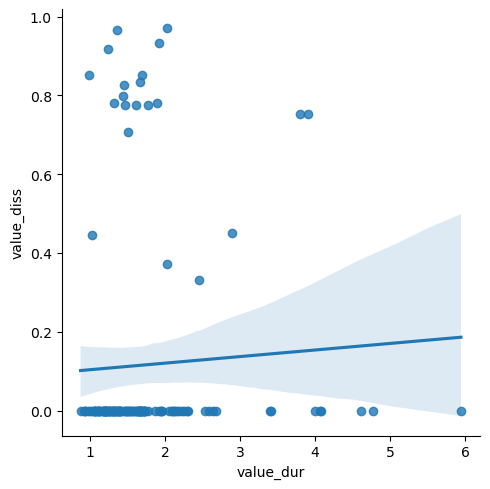

In [18]:
sns.lmplot(
    dd.query("subject.isin(@dd_subs.head(10)['subject'])"),
    x="value_dur",
    y="value_diss",
    fit_reg=True,
)

In [3]:
dd_q = dd.query("value_dur.notna() & value_dur < 70 & value_diss > 0")
dd_q["value_dur"].corr(dd_q["value_diss"])

0.10602247084192609

In [4]:
dd

,subject,variable,value_diss,value_dur
0,0,6294,0.0,1.939
1,1,6294,0.0,NaN
2,2,6294,0.0,NaN
3,3,6294,0.0,4.888
4,4,6294,0.0,NaN
...,...,...,...,...
56245,1245,6465,0.0,6.683
56246,1246,6465,0.0,2.714
56247,1247,6465,0.0,4.304
56248,1248,6465,0.0,17.922


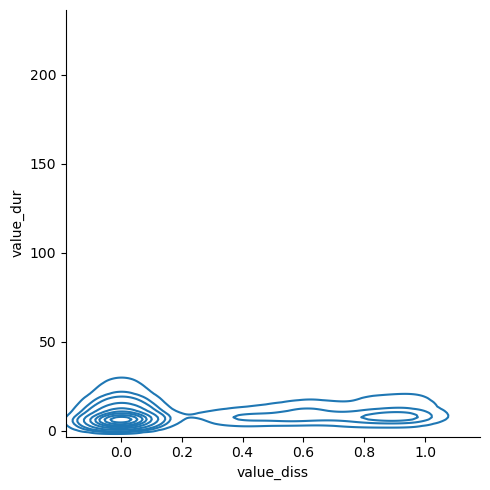

In [6]:
sns.displot(data=dd, x="value_diss", y="value_dur", kind="kde")

In [45]:
def _diss_duration_corr(diss_matrix, n_head=100):
    bond_diss = pd.melt(diss_matrix.reset_index(names="subject"), id_vars="subject")

    dd = pd.merge(
        bond_diss,
        pd.melt(bond_durations.reset_index(names="subject"), id_vars="subject"),
        how="left",
        on=["subject", "variable"],
        suffixes=("_diss", "_dur"),
    )

    dd_subs = dd.groupby("subject", as_index=False).mean().sort_values(by="value_dur")

    def _get_hcorr(n_head):
        dd_sq = dd_subs.head(n_head)

        return dd_sq["value_dur"].corr(dd_sq["value_diss"])

    def _get_tcorr(n_tail):
        dd_sq = dd_subs.tail(n_tail)

        return dd_sq["value_dur"].corr(dd_sq["value_diss"])

    hcor = [_get_hcorr(i) for i in range(3, n_head)]
    tcor = [_get_tcorr(i) for i in range(3, n_head)]

    return pd.DataFrame({"n": range(3, n_head), "n fastest": hcor, "n slowest": tcor})

<AxesSubplot:xlabel='n', ylabel='value'>

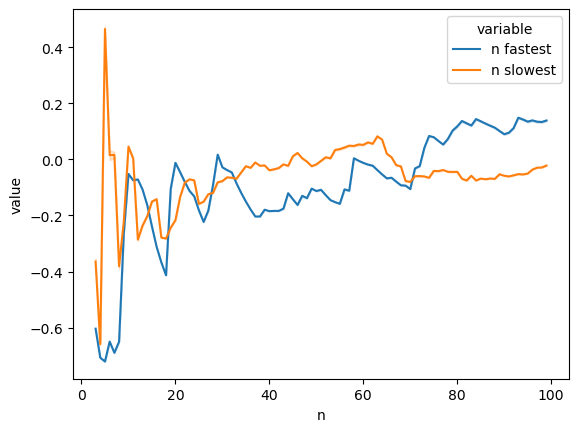

In [46]:
ddc = [
    _diss_duration_corr(pd.read_csv(df))
    for df in glob.glob("data/bondcourt/bondcourt_dissonance*.csv")
]

ddc = pd.melt(pd.concat(ddc), id_vars="n")

sns.lineplot(ddc, x="n", y="value", hue="variable")

In [47]:
conf = 0.95

ddc_ci_var = ddc.groupby(["n", "variable"], as_index=False).agg(
    mean=pd.NamedAgg(column="value", aggfunc="mean"),
    var=pd.NamedAgg(column="value", aggfunc="var"),
    ci=pd.NamedAgg(
        column="value",
        aggfunc=lambda x: sms.DescrStatsW(x).tconfint_mean(alpha=1 - conf),
    ),
)

ddc_ci_var

,n,variable,mean,var,ci
0,3,n fastest,-0.604191,0.000019,"(-0.6073063298304849, -0.601075611232854)"
1,3,n slowest,-0.364610,0.000410,"(-0.3791005439354683, -0.35011870054177474)"
2,4,n fastest,-0.707746,0.000010,"(-0.7100203958885387, -0.7054713213811796)"
3,4,n slowest,-0.659176,0.000071,"(-0.6651852138789708, -0.6531663391601944)"
4,5,n fastest,-0.721375,0.000007,"(-0.7232431511991135, -0.7195072022759541)"
...,...,...,...,...,...
189,97,n slowest,-0.029297,0.000002,"(-0.03024875551031966, -0.028344939066146577)"
190,98,n fastest,0.133912,0.000021,"(0.13067307898053124, 0.13715091804382243)"
191,98,n slowest,-0.028589,0.000004,"(-0.030061725928132138, -0.02711612203131311)"
192,99,n fastest,0.139222,0.000020,"(0.1360317204704076, 0.14241288382257775)"


In [49]:
ddc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns").to_csv(
    "data/bondcourt/diss_dur_corr_ci_var.csv", index=False
)

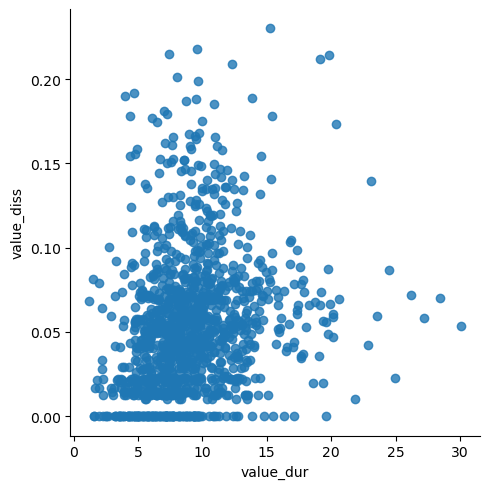

In [15]:
sns.lmplot(dd_subs, x="value_dur", y="value_diss", fit_reg=False)

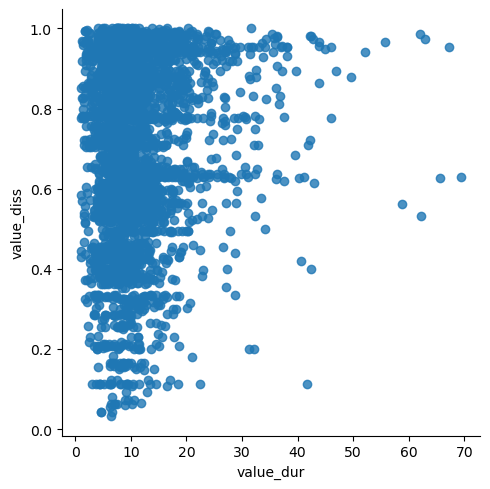

In [7]:
sns.lmplot(
    dd.query("value_dur.notna() & value_dur < 70 & value_diss > 0"),
    x="value_dur",
    y="value_diss",
    fit_reg=False,
)

In [ ]:
sns.lmplot(
    dd.query("value_dur.notna()"),
    x="value_dur",
    y="value_diss",
    fit_reg=False,
    col="variable",
    col_wrap=4,
    sharey=False,
)

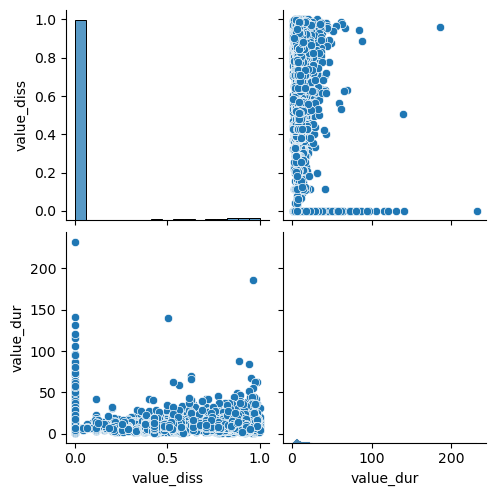

In [38]:
sns.pairplot(
    dd,
    vars=["value_diss", "value_dur"],
)

In [15]:
bond_diss.corrwith(bond_durations).sort_values(ascending=False)

6366    0.595434
6348    0.400497
6393    0.312004
6314    0.275644
6317    0.268343
6394    0.260347
6294    0.254542
6373    0.245749
6412    0.243955
6408    0.234076
6422    0.209906
6391    0.203357
6319    0.195062
6436    0.189549
6352    0.184100
6353    0.176760
6387    0.175391
6328    0.164626
6411    0.152715
6399    0.148577
6315    0.143240
6296    0.139661
6409    0.124043
6385    0.110714
6363    0.095641
6426    0.084970
6392    0.080438
6325    0.020901
6421    0.017634
6400    0.011919
6362   -0.042902
6410   -0.045115
6327   -0.082335
6356   -0.103941
6427   -0.124186
6298         NaN
6326         NaN
6358         NaN
6374         NaN
6382         NaN
6386         NaN
6390         NaN
6463         NaN
6464         NaN
6465         NaN
dtype: float64

-----

------------